In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, ReLU
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

from sklearn.metrics import classification_report

import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# mounting google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/Bone_Fracture_Binary_Classification/train'
val_path = '/content/drive/MyDrive/Bone_Fracture_Binary_Classification/val'
test_path = '/content/drive/MyDrive/Bone_Fracture_Binary_Classification/test'
class_names = []
files_and_folders = os.listdir(train_path)

for item in files_and_folders:
    class_names.append(item)

In [ ]:
class_names

['fractured', 'not fractured']

In [ ]:
#function to load and preprocess the images using cv2 library
def import_data(dataset, path, categories):
    for i in categories:
        full_path = os.path.join(path,i)
        label = []
        if i == 'fractured':
            label = [0,1]
        elif i == 'not fractured':
            label = [1,0]

        for j in os.listdir(full_path):
            try:
                img = cv2.imread(os.path.join(full_path,j))
                img = cv2.cvtColor(img , cv2.COLOR_RGB2BGR)
                img_resized = cv2.resize(img,(224,224))
                dataset.append([img_resized,label])
            except :
                pass
    random.shuffle(dataset)

# creating the dataset

train_df = []
import_data(train_df,train_path,class_names)
train_df = pd.DataFrame(train_df,columns=['image','label'])
train_stack = np.stack(train_df.image)
train_stack_label = np.stack(train_df.label)

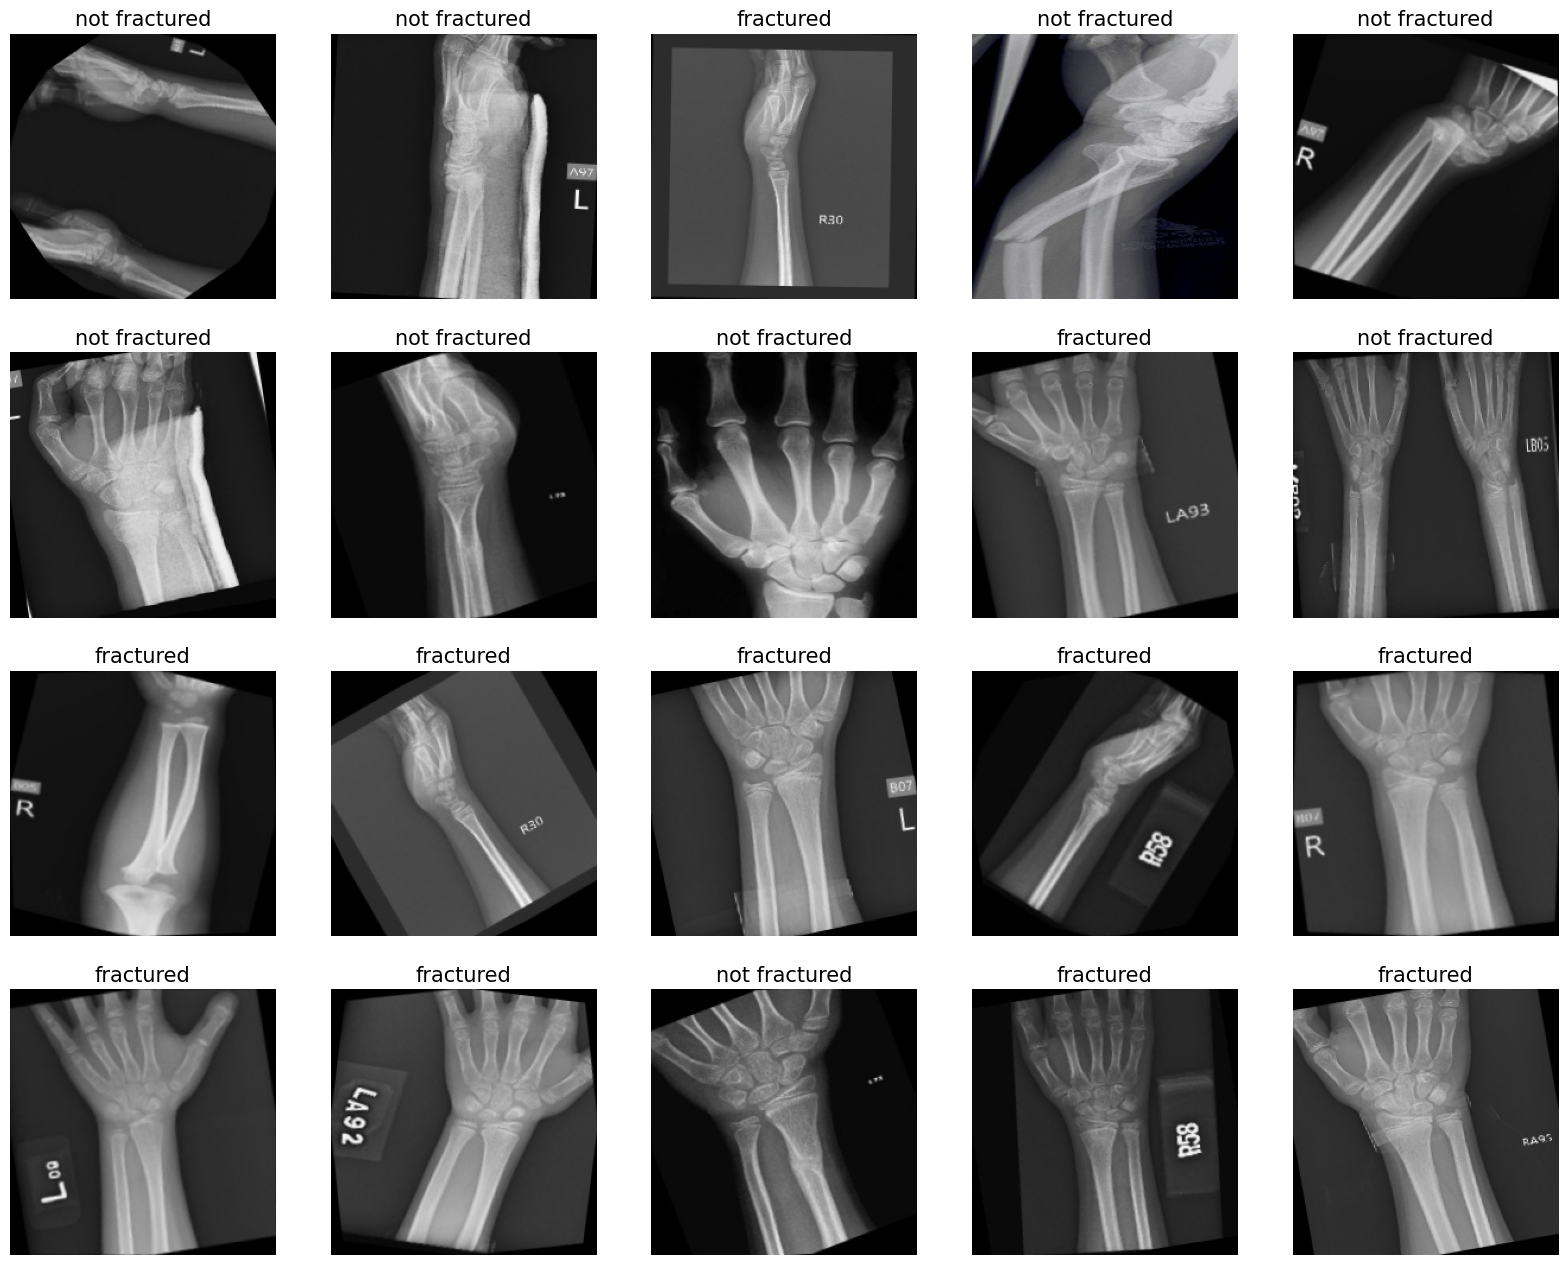

In [ ]:
# printing first 20 images of dataset
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.imshow(train_df.image[i])
    plt.title(class_names[np.argmax(train_df.label[i])],size=15)
    plt.axis('off')

In [ ]:
#creating validation and testing dataset
val_df = []
import_data(val_df,val_path,class_names)
val_df = pd.DataFrame(val_df,columns=['image','label'])
val_stack = np.stack(val_df.image)
val_stack_label = np.stack(val_df.label)

test_df = []
import_data(test_df,test_path,class_names)
test_df = pd.DataFrame(test_df,columns=['image','label'])
test_stack = np.stack(test_df.image)
test_stack_label = np.stack(test_df.label)

In [ ]:
# printing the size of each of the three datasets
print(f'train : {len(train_df)}')
print(f'val : {len(val_df)}')
print(f'test : {len(test_df)}')

train : 9243
val : 829
test : 506


In [ ]:
# model VGG16 + 2CNN
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(
    include_top = False,
    weights='imagenet',
    input_shape = (224,224,3))

vgg16.trainable = False

# let's build and train the model
model = Sequential()
model.add(vgg16)
model.add(layers.Conv2D(32,(3,3),padding='same',
                           activation = 'relu',
                           kernel_regularizer = keras.regularizers.l2(0.04)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(32,(5,5),padding='same',
                           activation = 'relu',
                           kernel_regularizer = keras.regularizers.l2(0.04)))
model.add(layers.Dropout(0.4))
# ann layers
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=64,activation='relu',kernel_regularizer = keras.regularizers.l2(0.04)))
model.add(layers.Dropout(0.5))

#no of classes is 2
model.add(layers.Dense(units=2,activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.00015),
                 loss= 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_34 (Conv2D)          (None, 7, 7, 32)          147488    
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 conv2d_35 (Conv2D)          (None, 7, 7, 32)          25632     
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 flatten_3 (Flatten)         (None, 1568)              0         
                                                                 
 batch_normalization_17 (Ba  (None, 1568)             

In [ ]:
#creating the test dataset
train_stack_lb = np.stack(train_df.label)
train_val_lb = np.stack(val_df.label)
train_stack[1].shape

(224, 224, 3)

In [ ]:
# training the model
model.fit(train_stack,train_stack_label,epochs=20, validation_data = (val_stack,val_stack_label) , callbacks= early_stopping)

Epoch 1/20
289/289 [==============================] - 187s 640ms/step - loss: 7.0875 - accuracy: 0.6785 - val_loss: 4.9448 - val_accuracy: 0.8866
Epoch 2/20
289/289 [==============================] - 185s 641ms/step - loss: 3.6790 - accuracy: 0.9328 - val_loss: 2.6494 - val_accuracy: 0.9445
Epoch 3/20
289/289 [==============================] - 187s 648ms/step - loss: 1.9386 - accuracy: 0.9867 - val_loss: 1.4188 - val_accuracy: 0.9819
Epoch 4/20
289/289 [==============================] - 185s 639ms/step - loss: 1.0606 - accuracy: 0.9942 - val_loss: 0.8059 - val_accuracy: 0.9807
Epoch 5/20
289/289 [==============================] - 183s 635ms/step - loss: 0.6029 - accuracy: 0.9966 - val_loss: 0.5132 - val_accuracy: 0.9723
Epoch 6/20
289/289 [==============================] - 183s 635ms/step - loss: 0.3704 - accuracy: 0.9948 - val_loss: 0.3076 - val_accuracy: 0.9879
Epoch 7/20
289/289 [==============================] - 184s 636ms/step - loss: 0.2542 - accuracy: 0.9933 - val_loss: 0.2327 -

In [ ]:
# plotting learning accuracy and loss
history_acc = model.history.history['accuracy']
history_val_acc = model.history.history['val_accuracy']
history_loss = model.history.history['loss']
history_val_loss = model.history.history['val_loss']

<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>

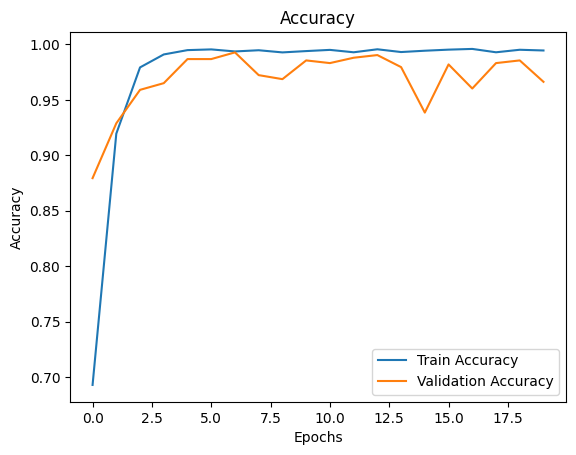

In [ ]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
sns.lineplot(data = history_acc, label = 'Train Accuracy')
sns.lineplot(data = history_val_acc, label = 'Validation Accuracy')

<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>

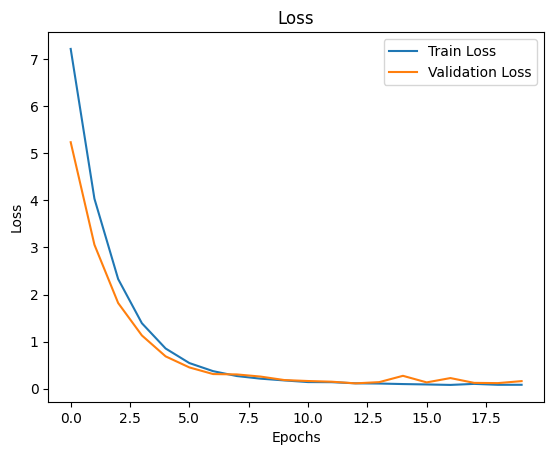

In [ ]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
sns.lineplot(data = history_loss, label = 'Train Loss')
sns.lineplot(data = history_val_loss, label = 'Validation Loss')


In [ ]:
# to benchmark performance on real world data we will use different metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
def prediction(model,test_stack = test_stack, test_df = test_stack_label):

    output = model.predict(test_stack)
    output = np.round(output)
    prediction = output
    print("-"*100)
    print(f'Accuracy Score : {accuracy_score(test_stack_label,prediction)}')
    print(f'Precision Score : {precision_score(test_stack_label,prediction, average="weighted")}')
    print(f'Recall Score : {recall_score(test_stack_label,prediction, average="weighted")}')
    print(f'F1 Score : {f1_score(test_stack_label,prediction, average="weighted")}')

prediction(model)

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

2024-05-19 13:14:14.315931: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.46443, expected 2.59124
2024-05-19 13:14:14.315995: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.84232, expected 3.96913
2024-05-19 13:14:14.316005: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.91526, expected 4.04207
2024-05-19 13:14:14.316013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.02814, expected 4.15494
2024-05-19 13:14:14.316021: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.53562, expected 3.66243
2024-05-19 13:14:14.316029: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.79722, expected 3.92403
2024-05-19 13:14:14.316036: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.69349, expected 3.82029
2024-05-19 13:14:14.316044: E external/local_xla/xla/se

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 907ms/step
----------------------------------------------------------------------------------------------------
Accuracy Score : 0.9822134387351779
Precision Score : 0.9822168176353044
Recall Score : 0.9822134387351779
F1 Score : 0.982211277083118


In [ ]:
ls=[]
for i in test_stack_label:
    ls.append(np.argmax(i))

test_stack_one_label = np.array(ls)

In [ ]:
import seaborn as sns
def  plot_confusion_matrix(model,test_stack = test_stack, test_label = test_stack_one_label):
    ''' we will Print the confusion matrix '''

    output = model.predict(test_stack)
    output = np.round(output).astype(int)
    prediction = output
    ls=[]
    for i in output:
        ls.append(np.argmax(i))
    prediction = np.array(ls)

    accuracy = accuracy_score(test_label,prediction)
    # where the accuracy is more than 94% we will show the CM as blue...
    if accuracy > 0.94:
        cmap = 'Blues'
    else :
        cmap = 'Reds'
    cm = confusion_matrix(test_label, prediction)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


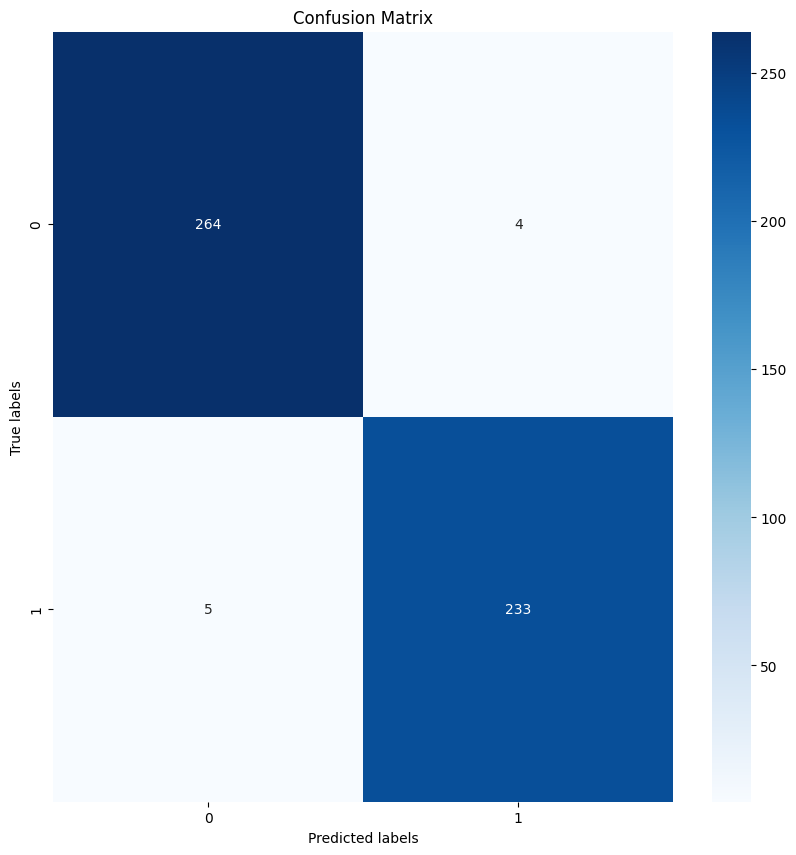

In [ ]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(model)